In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [5]:
path = Path("/kaggle/input/utkface-new/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [6]:
print(len(filenames))
print(filenames[:3])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [7]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [8]:
image_path

['39_0_1_20170113151528768.jpg.chip.jpg',
 '51_0_0_20170111203742983.jpg.chip.jpg',
 '34_0_1_20170116002253177.jpg.chip.jpg',
 '15_1_2_20170104012024121.jpg.chip.jpg',
 '22_1_0_20170116214345265.jpg.chip.jpg',
 '32_1_0_20170116201719833.jpg.chip.jpg',
 '39_0_3_20170104220721736.jpg.chip.jpg',
 '47_0_2_20170116184928912.jpg.chip.jpg',
 '26_1_1_20170116153243210.jpg.chip.jpg',
 '39_1_3_20170104234641563.jpg.chip.jpg',
 '35_1_1_20170112215253641.jpg.chip.jpg',
 '4_1_0_20170103181119880.jpg.chip.jpg',
 '74_0_0_20170116232642012.jpg.chip.jpg',
 '62_0_1_20170113142229676.jpg.chip.jpg',
 '68_1_0_20170110175703443.jpg.chip.jpg',
 '1_1_3_20161219225050632.jpg.chip.jpg',
 '39_0_0_20170104202635938.jpg.chip.jpg',
 '25_0_3_20170119171616945.jpg.chip.jpg',
 '30_0_0_20170117181259219.jpg.chip.jpg',
 '36_0_0_20170117183317229.jpg.chip.jpg',
 '71_0_0_20170104213443413.jpg.chip.jpg',
 '16_0_0_20170110232444834.jpg.chip.jpg',
 '24_0_0_20170117150031708.jpg.chip.jpg',
 '14_0_0_20170110224528797.jpg.chip.

# From Unstructured data to Structured data

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [10]:
df.head()

,image,age,gender
0,39_0_1_20170113151528768.jpg.chip.jpg,39,0
1,51_0_0_20170111203742983.jpg.chip.jpg,51,0
2,34_0_1_20170116002253177.jpg.chip.jpg,34,0
3,15_1_2_20170104012024121.jpg.chip.jpg,15,1
4,22_1_0_20170116214345265.jpg.chip.jpg,22,1


In [11]:
gender_dict = {0:"Male",1:"Female"}

In [12]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [13]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


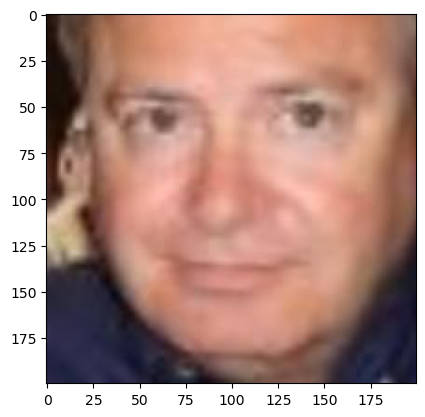

In [14]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/"+df.image[1])
plt.imshow(img)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='age', ylabel='Density'>

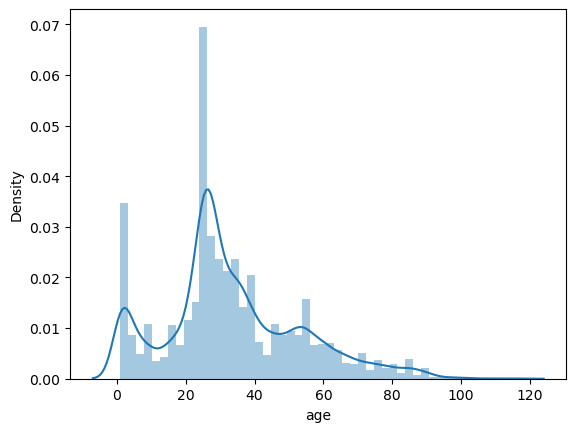

In [15]:
sns.distplot(df.age)

# Plotting Images

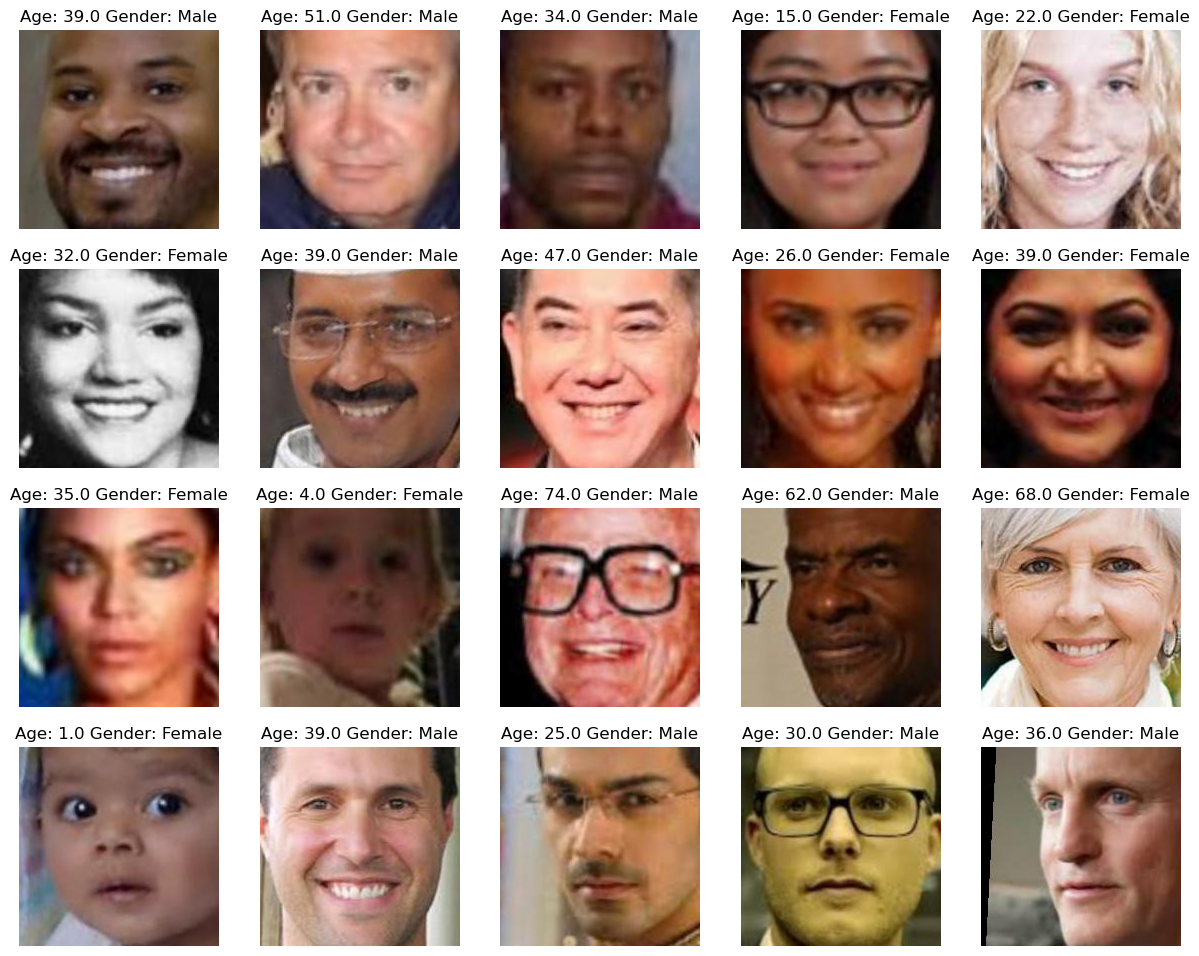

In [16]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [17]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [18]:
train.head()

,image,age,gender
18199,67_0_0_20170109150725032.jpg.chip.jpg,67.0,0
19557,25_1_0_20170116002150531.jpg.chip.jpg,25.0,1
20132,63_0_0_20170111171747607.jpg.chip.jpg,63.0,0
11849,26_0_4_20170117200038821.jpg.chip.jpg,26.0,0
2100,32_0_1_20170113152015975.jpg.chip.jpg,32.0,0


# Extracting Features

In [19]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/opt/conda/lib/python3.7/site-packages/keras/utils/image_utils.py:410: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  'grayscale is deprecated. Please use color_mode = "grayscale"'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  """


In [20]:
x_train.shape

(3556, 128, 128, 1)

# Normalizing data

In [21]:
x_train = x_train/255

In [22]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [23]:
input_size = (128,128,1)

# Creating model

In [24]:
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam

SIZE=128
N_ch=1

def build_alexnet():
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu')(input)
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dense(units=4096, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=4096, activation='relu')(x)
    x = Dropout(rate=0.5)(x)

    # multi output
    output_1 = Dense(units=1, activation='sigmoid', name='gender_output')(x)
    output_2 = Dense(units=1, activation='relu', name='age_output')(x)

    # model
    model = Model(inputs=input, outputs=[output_1, output_2])
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


# Training the model

In [25]:
model =build_alexnet()
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=30, validation_split= 0.1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 96)   11712       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 96)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 96)  384         ['max_pooling2d[0][0]']      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
320/320 [==============================] - 107s 330ms/step - loss: 17.1410 - gender_output_loss: 0.7369 - age_output_loss: 16.4041 - gender_output_accuracy: 0.5784 - age_output_accuracy: 0.0509 - val_loss: 14.8355 - val_gender_output_loss: 0.6351 - val_age_output_loss: 14.2004 - val_gender_output_accuracy: 0.6545 - val_age_output_accuracy: 0.0730
Epoch 2/30
320/320 [==============================] - 105s 327ms/step - loss: 14.2718 - gender_output_loss: 0.7194 - age_output_loss: 13.5524 - gender_output_accuracy: 0.6072 - age_output_accuracy: 0.0512 - val_loss: 13.5183 - val_gender_output_loss: 0.6027 - val_age_output_loss: 12.9155 - val_gender_output_accuracy: 0.6685 - val_age_output_accuracy: 0.0730
Epoch 3/30
320/320 [==============================] - 105s 327ms/step - loss: 13.5900 - gender_output_loss: 0.6584 - age_output_loss: 12.9316 - gender_output_accuracy: 0.6531 - age_output_accuracy: 0.0459 - val_loss: 13.6217 - val_gender_output_loss: 0.6511 - val_age_output_loss:

# Visualizing loss

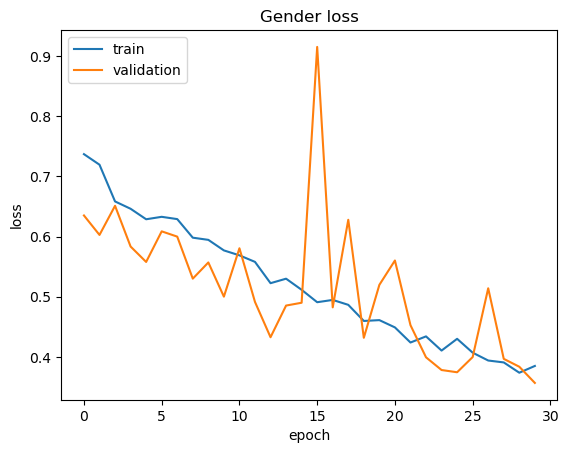

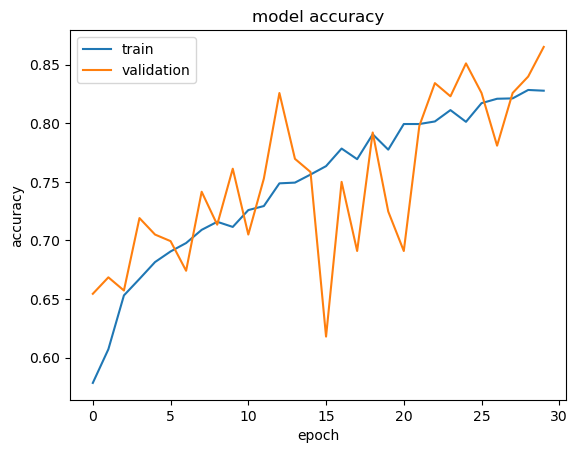

In [33]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

hist=model_history

plt.plot(hist.history['gender_output_accuracy'])
plt.plot(hist.history['val_gender_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

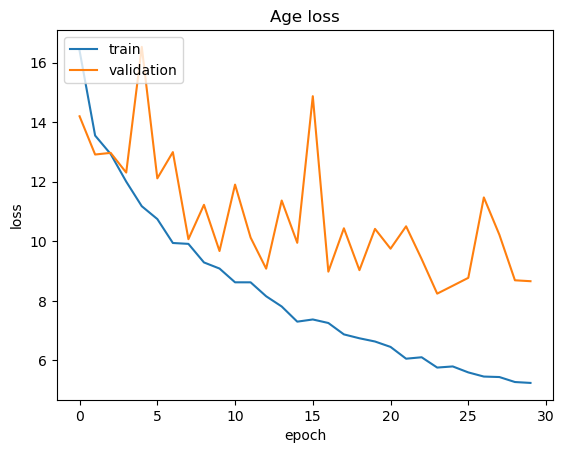

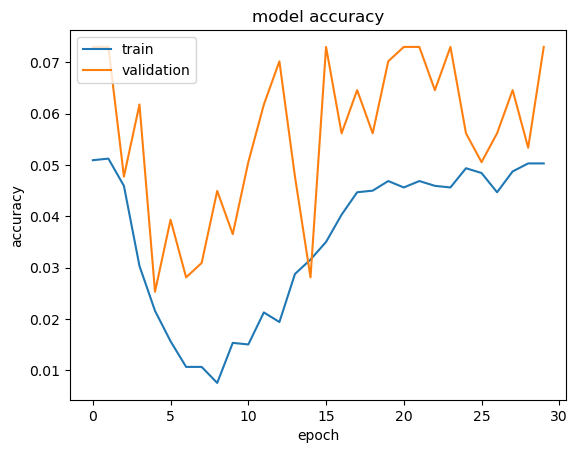

In [34]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['age_output_accuracy'])
plt.plot(hist.history['val_age_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Male  Age =  75.0
1/1 [==============================] - 0s 197ms/step
Prediction: Gender =  Male  Age =  60


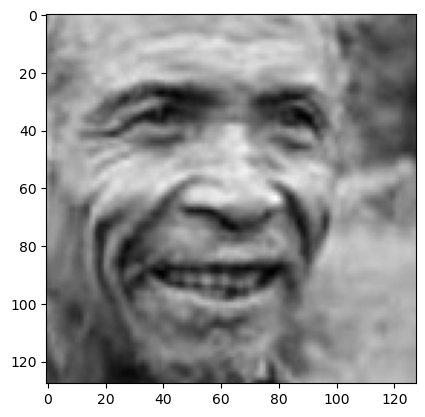

In [28]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

Original: Gender =  Male  Age =  30.0
1/1 [==============================] - 0s 50ms/step
Prediction: Gender =  Male  Age =  22


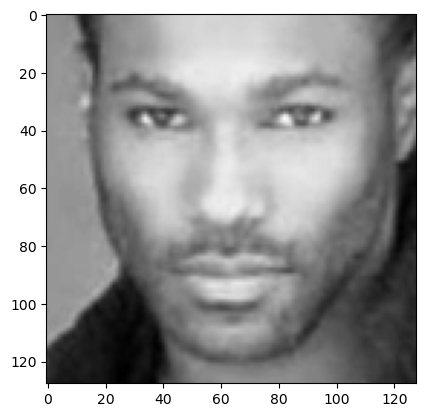

In [32]:
index=876
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')